In [2]:
# all the packages you need
from __future__ import division
import sys
import numpy as np
import time
import scipy.io as io
import scipy.sparse as sparse
import scipy.sparse.linalg 
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# synthetic data generator
# n is number of samples, d is number of dimensions, k is number of nonzeros in w, sigma is std of noise, 
# X is a n x d data matrix, y=Xw+w_0+noise is a n-dimensional vector, w is the true weight vector, w0 is true intercept
def DataGenerator(n = 50, d = 75, k = 5, sigma = 1.0, w0 = 0.0, seed = 256):
    
    np.random.seed(seed)
    X = np.random.normal(0,1,(n,d))
    w = np.random.binomial(1,0.5,k) #(n trails per experiment,prob of success,run k times)
    noise = np.random.normal(0,sigma,n)
    w[w == 1] = 10.0
    w[w == 0] = -10.0
    w = np.append(w, np.zeros(d - k))
    y = X.dot(w) + w0 + noise
    return (X, y, w, w0)

In [2]:
# initialization of W for lasso by least square regression or ridge regression
def Initialw(X, y):

    n, d = X.shape
    # increment X
    if sparse.issparse(X):
        XI = sparse.hstack((X, np.ones(n).reshape(n,1)))
    else:
        XI = np.hstack((X, np.ones(n).reshape(n,1)))

    if sparse.issparse(X):
        if n >= d:
            w = sparse.linalg.lsqr(XI, y)[0]
        else:
            w = sparse.linalg.inv(XI.T.dot(XI) + 1e-3 * sparse.eye(d+1)).dot(XI.T.dot(y)) #ridged
            w = w.T
    else:
        if n >= d:
            w = np.linalg.lstsq(XI, y)[0]
        else:
            w = np.linalg.inv(XI.T.dot(XI) + 1e-3 * np.eye(d+1)).dot(XI.T.dot(y))
 
    return (w[:d], w[d])

In [ ]:
# Problem 2.1
# coordinate descent of lasso, note lmda stands for lambda
def lasso(X, y, lmda = 10.0, epsilon = 1.0e-2, max_iter = 100, draw_curve = False):
    w, w0 = Initialw(X, y)
    n,dim = X.shape
    epoch = 0
    bias_col = np.ones(n)
    loss=[]
    wPrev = 0
    
    while epoch <= max_iter:
        # Coordinate descent
        for k in range(dim):
            xk = X[:,k]

            rks = y - ((X@w + w0) - w[k]*xk) # shape=(n,1)
            aks = np.dot(xk,xk) # scalar
            cks = np.dot(xk,rks) # scalar
            
            # coordinates update for k = 1:m (bias excluded)
            if (cks<=0): 
                w[k] = -max(0.0,abs(cks)-lmda)/aks
            else:  
                w[k] = max(0.0,abs(cks)-lmda)/aks #NOTE: np.max & np.maximum are used for getting max from arrays.
            
        
        # Update bias
        rks = y - X@w # shape=(n,1)
        aks = np.dot(bias_col,bias_col) # scalar
        cks = np.dot(bias_col,rks) # scalar
        w0 = cks/aks
        
        # calculate loss
        cost = np.dot(X@w+w0-y, X@w+w0-y) + lmda*np.sum(np.absolute(w))
        loss.append(cost)
        # stop conditions 
        epoch += 1
        
        if(epoch >1):
            wCurr = np.append(w,w0)
            if(np.max(np.absolute(wCurr-wPrev)) <= epsilon):
                break
                    
        wPrev = np.append(w,w0)
        
    # plot F(w,w0) w.r.t coordinate descent step (epoch)
    if draw_curve:
        fig, ax = plt.subplots(figsize=(10, 8))
        plt.plot(range(epoch),loss, c = 'blue', ls = '-', marker = 'x', label ='coordinate descent convergence curve')
        plt.grid()
        plt.legend()
        plt.xlabel('number of coordinate descent steps')
        plt.ylabel('loss')

    return (w,w0)

In [ ]:
# Problem 2.1: data generation
X, y, w_true, w0_true = DataGenerator(n=50, d=75, k=5, sigma=1.0)
# have a look at generated data and true model
print(X)
print(y)
print(w_true)
print(w0_true)

In [ ]:
# Problem 2.1: run lasso and plot the convergence curve
# run lasso for one synthetic data
w_lasso, w0_lasso = lasso(X, y, lmda = 10.0, epsilon = 1.0e-2, draw_curve = True, max_iter = 100)
# have a look at the lasso model you got (sparse? where?)
print("w: ", w_lasso)
print('w0: ', w0_lasso)
print("non-zero indices: ",np.nonzero(w_lasso)[0])
np.nonzero(w_lasso)[0].size

In [ ]:
# Problem 2.2
# evaluation function of lasso model
def root_mean_square_error(pred, y):
    #TODO
    diff = pred - y
    rmse = np.sqrt(np.dot(diff,diff)/len(diff))
    return rmse

def Evaluate(X, y, w, w0, w_true, w0_true):
    # rmse
    pred = X@w + w0
    rmse = root_mean_square_error(pred,y)
    
    #sparsity - non-zero elements
    sparsity_w = np.nonzero(w)[0].size
    
    #precision & recall
    if (len(np.nonzero(w)[0]) == 0):
        if (len(np.nonzero(w_true)[0]) == 0):
            precision_w = 1.0
        else:
            precision_w = 0.0
    else:
        precision_w = len(set(np.nonzero(w)[0]) & set(np.nonzero(w_true)[0])) / len(np.nonzero(w)[0])

    recall_w = len(set(np.nonzero(w)[0]) & set(np.nonzero(w_true)[0])) / len(np.nonzero(w_true)[0])
    
    return (rmse, sparsity_w, precision_w, recall_w)

In [ ]:
# Problem 2.2
# apply your evaluation function to compute precision (of w), recall (of w), sparsity (of w) and training RMSE
Emetric = Evaluate(X, y, w_lasso, w0_lasso, w_true, w0_true)
print(f'rmse: {Emetric[0]}')
print(f'sparsity_w: {Emetric[1]}')
print(f'precision_w: {Emetric[2]}')
print(f'recall_w: {Emetric[3]}')

In [ ]:
# Problem 2.3
# compute a lasso solution path, draw the path(s) in a 2D plot
def LassoPath(X, y,sigma):
    numSamples,dim = X.shape
    lamda_max = np.max(np.absolute(np.dot((y-np.mean(y)),X)))
    Lmda = np.linspace(lamda_max,0,num=50) #shape=(1,50)
    W = np.zeros((dim,len(Lmda))) #(75,50)
    W0 = np.zeros(len(Lmda)) #(50,)
        
    for i in range(len(Lmda)):
    
        w_lasso, w0_lasso = lasso(X, y, Lmda[i], epsilon = 1.0e-2, draw_curve = False, max_iter = 100)
        W0[i]=w0_lasso
        #print(W.shape)
        #print(w_lasso.shape)
        W[:,i] = w_lasso
       
    # plot lasso solution path
    cl = ['blue', 'red']
    fig, ax = plt.subplots(figsize=(10, 8))
    plt.plot(Lmda[:,None],W.T[:,0:5], c = cl[0], ls = '-', marker = 'o', ms=3, alpha=0.5, label = '5 features')
    plt.plot(Lmda[:,None],W.T[:,5:], c = cl[1], ls = '-', marker = 'o', ms=2.5, alpha=0.3, label = 'rest of features')
    
#     ax.set_ylim([-10, 10])
    plt.grid()
    '''prevent multiple labels from being printed'''
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.title('n=%d, m=%d, sigma=%f' %(numSamples,dim,sigma))
    plt.xlabel('lamda')
    plt.ylabel('Weights')
    

    return (W, W0, Lmda)


In [ ]:
# Problem 2.3
# evaluate a given lasso solution path, draw plot of precision/recall vs. lambda
def EvaluatePath(X, y, W, W0, w_true, w0_true, Lmda,sigma):
    numSamples,dim = X.shape
    dim, n = W.shape # n= number of lamdas
    RMSE = np.zeros(n)
    Sparsity = np.zeros(n)
    Precision = np.zeros(n)
    Recall = np.zeros(n)
    
    for i in range(n):
        w = W[:,i]
        w0 = W0[i]
        
        rmse, sparsity_w, precision_w, recall_w = Evaluate(X, y, w, w0, w_true, w0_true)

        RMSE[i] = rmse
        Sparsity[i] = sparsity_w
        Precision[i] = precision_w 
        Recall[i] = recall_w
        
    # precision/recall vs. lambda curves
    cl = ['cyan', 'green']
    fig, ax = plt.subplots(figsize=(10, 8))
    plt.plot(Lmda,Precision, c = cl[0], ls = '-', marker = 'o',ms=3,alpha=1, label = 'Precision')
    plt.plot(Lmda,Recall, c = cl[1], ls = '-', marker = 'o',ms=3,alpha=1, label = 'Recall')
    
    plt.grid()
    plt.legend()
    plt.title('n=%d, m=%d, sigma=%f' %(numSamples,dim,sigma))
    plt.xlabel('lamda')
    plt.ylabel('Precision/Recall accuracy')
    
    return (RMSE, Sparsity, Precision, Recall)

In [ ]:
# Problem 2.3
# TODO: draw lasso solution path and precision/recall vs. lambda curves
X, y, w_true, w0_true = DataGenerator(n=50, d=75, k=5, sigma=1.0)

W, W0, Lmda = LassoPath(X, y,1.0)

EvaluatePath(X, y, W, W0, w_true, w0_true, Lmda,1.0)

In [ ]:
# Problem 2.3
# try a larger std sigma = 10.0
X, y, w_true, w0_true = DataGenerator(n=50, d=75, k=5, sigma=10.0)

W, W0, Lmda = LassoPath(X, y,10.0)
print(Lmda)
EvaluatePath(X, y, W, W0, w_true, w0_true, Lmda,10.0)

In [ ]:
n = [50,200,7000]
m = [75,150,900]
#(n = 50,m = 75),(n = 50,m = 150),(n = 50,m = 1000),(n = 100,m = 75),(n = 100,m = 150),(n = 100,m = 1000)
for sampleSize in n:
    for dim in m:

        X, y, w_true, w0_true = DataGenerator(n=sampleSize, d=dim, k=5, sigma=1.0)
        W, W0, Lmda = LassoPath(X, y,1.0)
        EvaluatePath(X, y, W, W0, w_true, w0_true, Lmda,1.0)

In [ ]:
# Problem 2.4
# try another 5 different choices of (n,d) 
# draw lasso solution path and precision/recall vs. lambda curves, use them to estimate the lasso sample complexity
n = [50,100]
m = [75,150,1000]
#(n = 50,m = 75),(n = 50,m = 150),(n = 50,m = 1000),(n = 100,m = 75),(n = 100,m = 150),(n = 100,m = 1000)
for sampleSize in n:
    for dim in m:

        X, y, w_true, w0_true = DataGenerator(n=sampleSize, d=dim, k=5, sigma=1.0)
        W, W0, Lmda = LassoPath(X, y,1.0)
        EvaluatePath(X, y, W, W0, w_true, w0_true, Lmda,1.0)

In [ ]:
"""
Sparse Matrix Operations
    Sparse matrix: X. vector v
    csc: X.dot(v)


"""


In [ ]:
# Helper and example function of sparse matrix operation for Problem 2.5
# W: a scipy.sparse.csc_matrix
# x: a vector with length equal to the number of columns of W
# In place change the data stored in W,
# so that every row of W gets element-wise multiplied by x
def cscMatInplaceEleMultEveryRow(W, x):
    indptr = W.indptr
    last_idx = indptr[0]
    for col_id, idx in enumerate(indptr[1:]):
        if idx == last_idx:
            continue
        else:
            W.data[last_idx:idx] *= x[col_id]
            last_idx = idx

In [3]:
def SparseLasso(X, y, lmda = 10.0, epsilon = 1.0e-2, max_iter = 100, draw_curve = False):
    w, w0 = Initialw(X, y) #w, w0, y not sparse. X is sparse
    n,dim = X.shape
    epoch = 0
    bias_col = np.ones(n)
    loss=[]
    wPrev = 0
    
    #Sparse matrix, X's parameters
    data = X.data
    indptr = X.indptr
    indices = X.indices # row 
    
    while epoch <= max_iter:
        # Coordinate descent
        
        for k in range(dim):
            #xk = X[:,k] #dense
            xk = data[indptr[k]:indptr[k+1]] #Extract k's col of X. xk is an array of non-zero elements in col k of X
            xkInd = indices[indptr[k]:indptr[k+1]]
            XdotW = X.dot(w)
            XdotW[xkInd] -= w[k]*xk 
            rks = y - (XdotW+w0) #dense
    
#             rks = y - ((X@w + w0) - w[k]*xk) # shape=(n,1), dense
            aks = np.dot(xk,xk) # scalar
            cks = np.dot(xk,rks[xkInd]) # scalar
            
            # coordinates update for k = 1:m (bias excluded)
            if (cks<=0): 
                w[k] = -max(0.0,abs(cks)-lmda)/aks
            else:  
                w[k] = max(0.0,abs(cks)-lmda)/aks #NOTE: np.max & np.maximum are used for getting max from arrays.
                   
        # Update bias
        rks = y - X.dot(w) # shape=(n,1)
        aks = np.dot(bias_col,bias_col) # scalar
        cks = np.dot(bias_col,rks) # scalar
        w0 = cks/aks
        
        # calculate loss      
        cost = np.dot(X.dot(w)+w0-y, X.dot(w)+w0-y) + lmda*np.sum(np.absolute(w))
        loss.append(cost)
        
        # stop conditions 
        epoch += 1
        if(epoch >1):
            wCurr = np.append(w,w0)
            if(np.max(np.absolute(wCurr-wPrev)) <= epsilon):
                break
                    
        wPrev = np.append(w,w0)
        
    # plot F(w,w0) w.r.t coordinate descent step (epoch)
    if draw_curve:
        fig, ax = plt.subplots(figsize=(10, 8))
#         print(range(epoch))
#         print(loss)
        plt.plot(range(epoch),loss, c = 'blue', ls = '-', marker = 'x', label ='coordinate descent convergence curve')
        plt.grid()
        plt.legend()
        plt.xlabel('number of coordinate descent steps')
        plt.ylabel('loss')
    #     print(w)
    #     print(w0)
    return (w,w0,epoch)

In [4]:
# lasso that handles sparse matrices to improve efficiency
def SparseLassoPath(X, y,Lmda):
    W = np.zeros((X.shape[1],len(Lmda))) 
    W0 = np.zeros(len(Lmda)) 
    
    
    for i in range(len(Lmda)):
        start = time.time()
        
        w_lasso, w0_lasso, epoch = SparseLasso(X, y, Lmda[i], epsilon = 1.0e-2, draw_curve = False, max_iter = 100)
        
        elapsed_time = time.time()-start
        print(f'elapsed Time: {elapsed_time}s, lamda: {Lmda[i]}, iter: {epoch}, t/iter: {elapsed_time/epoch}s')
        
        W0[i] = w0_lasso
        #print(W.shape)
        #print(w_lasso.shape)
        W[:,i] = w_lasso
        
       
    # plot lasso solution path
    cl = ['blue', 'red']
    fig, ax = plt.subplots(figsize=(10, 8))
    plt.plot(Lmda[:,None],W.T, c = cl[0], ls = '-', marker = 'o', ms=2, alpha=0.2, label = 'features')
    #plt.plot(Lmda[:,None],W.T[:,5:], c = cl[1], ls = '-', marker = 'o', ms=2.5, alpha=0.3, label = 'rest of features')
    
#     ax.set_ylim([-10, 10])
    plt.grid()
    '''prevent multiple labels from being printed'''
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
#     print(by_label)
#     plt.title('noise sigma = %f ' %(sigma))
    plt.xlabel('lamda')
    plt.ylabel('Weights')
    

    return (W, W0, Lmda)

In [5]:
def root_mean_square_error(pred, y):
    #TODO
    diff = pred - y
    rmse = np.sqrt(np.dot(diff,diff)/len(diff))
    return rmse

def plot_rmse(X_train, y_train, X_valid, y_valid, W, W0, Lmda):
    rmse_train = []
    rmse_val = []
    
    for i ,lamda in enumerate(Lmda):
        pred = X_train.dot(W[:,i]) + W0[i]
        rmse_train.append(root_mean_square_error(pred, y_train))
        
        pred = X_valid.dot(W[:,i]) + W0[i]
        rmse_val.append(root_mean_square_error(pred, y_valid))
        
        
    fig, ax = plt.subplots(figsize=(10, 8))
    plt.plot(Lmda,rmse_train, c = 'red', ls = '-', marker = 'o',ms=3,alpha=1, label = 'rmse_train')
    plt.plot(Lmda,rmse_val, c = 'green', ls = '-', marker = 'o',ms=3,alpha=1, label = 'rmse_val')   
    plt.grid()
    plt.legend()
    plt.xlabel('lamda')
    plt.ylabel('rmse')
    
    return (rmse_train,rmse_val)
    

In [6]:
# Problem 2.5: predict reviews' star on Yelp
# data parser reading yelp data
def DataParser(Xfile, yfile, nfile, train_size = 4000, valid_size = 1000):

    # read X, y, feature names from file
    fName = open(nfile).read().splitlines()
    y = np.loadtxt(yfile, dtype=np.int) #not sparse
    if Xfile.find('mtx') >= 0:
        # sparse data
        X = io.mmread(Xfile).tocsc()
    else:
        # dense data
        X = np.genfromtxt(Xfile, delimiter=",")

    # split training, validation and test set
    X_train = X[0 : train_size,:]
    y_train = y[0 : train_size]
    X_valid = X[train_size : train_size + valid_size,:]
    y_valid = y[train_size : train_size + valid_size]
    X_test = X[train_size + valid_size : np.size(X,0),:] #np.size(X,axis): return the number of elements in a given axis
    y_test = y[train_size + valid_size : np.size(y,0)]

    return (X_train, y_train, X_valid, y_valid, X_test, y_test, fName)

In [9]:
# Problem 2.5: predict reviews' star on Yelp
# evaluation funtion that computes the lasso path, evaluates the result, and draws the required plots
def Validation(X_train, y_train, X_valid, y_valid):
    #########TODO##########
    # Regularization parameter generated from training X and y
    lamda_max = np.max(np.absolute(X_train.transpose().dot(y_train-np.mean(y_train))))
    Lmda = np.linspace(lamda_max, 0.06*lamda_max, num=20) #shape
    print('Lmda: ', Lmda)
    
    #Training
    #SparseLassoPath -> (W, W0, Lmda)
    W, W0, Lmda = SparseLassoPath(X_train, y_train,Lmda)
    
    #plot rmse -> (rmse_train,rmse_val)
    rmse_train, rmse_val = plot_rmse(X_train, y_train, X_valid, y_valid, W, W0, Lmda)  
    
    # best parameters corresponding to best lamda 
    w_lasso = W[:,np.argmin(rmse_val)]
    w0_lasso = W0[np.argmin(rmse_val)]
    lmda_best = Lmda[np.argmin(rmse_val)]
    
    return (w_lasso, w0_lasso, lmda_best)

Lmda:  [39.57825401 37.62017197 35.66208993 33.70400789 31.74592585 29.78784381
 27.82976177 25.87167973 23.91359769 21.95551565 19.99743361 18.03935157
 16.08126953 14.12318748 12.16510544 10.2070234   8.24894136  6.29085932
  4.33277728  2.37469524]
elapsed Time: 73.5420618057251s, lamda: 39.57825401364829, iter: 14, t/iter: 5.25300441469465s
elapsed Time: 73.98978734016418s, lamda: 37.62017197297306, iter: 14, t/iter: 5.284984810011728s
elapsed Time: 77.30341935157776s, lamda: 35.66208993229783, iter: 15, t/iter: 5.153561290105184s
elapsed Time: 78.11288332939148s, lamda: 33.704007891622595, iter: 15, t/iter: 5.207525555292765s
elapsed Time: 86.67565417289734s, lamda: 31.745925850947366, iter: 17, t/iter: 5.098567892523373s
elapsed Time: 95.44694781303406s, lamda: 29.787843810272136, iter: 19, t/iter: 5.023523569107056s
elapsed Time: 95.90239238739014s, lamda: 27.829761769596903, iter: 19, t/iter: 5.047494336178429s
elapsed Time: 100.81283688545227s, lamda: 25.87167972892167, iter: 

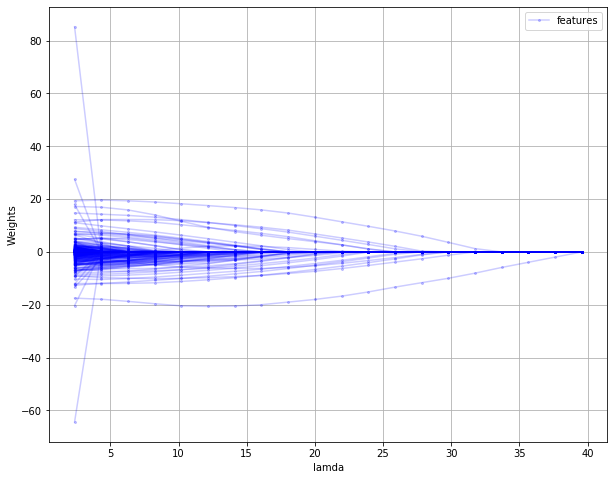

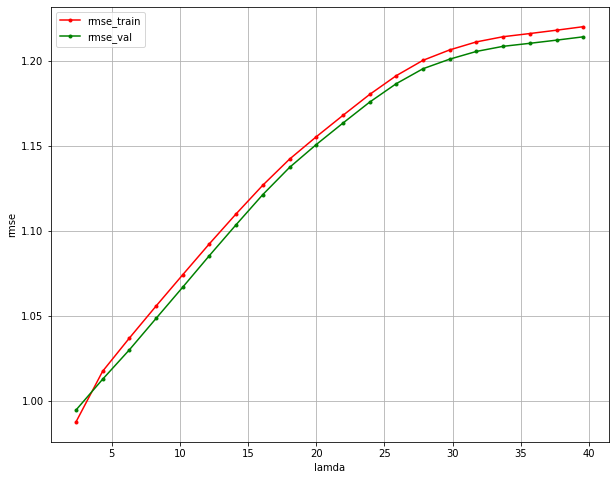

In [10]:
# Problem 2.5: predict reviews' star on Yelp
# evaluation of your results

# load Yelp data: change the address of data files on your own machine if necessary ('../data/' in the below)
from scipy.sparse.linalg import lsqr
X_train, y_train, X_valid, y_valid, X_test, y_test, fName = DataParser('./star_data.mtx', './star_labels.txt', './star_features.txt', 30000, 5000)

# # evaluation
w_lasso, w0_lasso, lmda_best = Validation(X_train, y_train, X_valid, y_valid)
print('lmda_best: ', lmda_best)

# rmse on test set
pred = X_test.dot(w_lasso) + w0_lasso
rmse_test = root_mean_square_error(pred,  y_test)
print('rmse_test: ', rmse_test)

# print the top-10 features you found by lasso
print('---------------------------------')
idx = (-np.abs(w_lasso)).argsort()[0:10]
print('Lasso select features:')
for i in range(10):
    print(fName[idx[i]],w_lasso[idx[i]])